In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function

In [19]:
def sigmoid_interpolation(start, end, steps):
    """
    Interpolates between start and end values using a sigmoid function over a specified number of steps.
    """
    x = np.linspace(-6, 6, steps)  # Range chosen to cover the significant transition of the sigmoid curve
    y = expit(x)  # Sigmoid function
    interpolated_values = start + (end - start) * y
    return interpolated_values

In [20]:
import pandas as pd

# Define file paths and corresponding new column name prefixes
files_and_columns = {
    '../data/sst_SanPablo.csv': 'SanPablo',
    '../data/sst_Alameda.csv': 'Alameda',
    '../data/sst_SanGregorio.csv': 'SanGregorio',
    '../data/sst_Farallones.csv': 'Farallones'
}

# Initialize an empty list to hold DataFrames
dfs = []

# Process each file
for file_path, location_prefix in files_and_columns.items():
    # Load CSV file into DataFrame
    df = pd.read_csv(
        file_path,
        parse_dates=['time'],
        index_col='time'
    )
    
    # Select both 'sst_at_location' and 'sst_upwelling_dif' columns
    # Rename them using the location prefix
    df = df[['sst_at_location', 'sst_upwelling_dif']].rename(
        columns={
            'sst_at_location': f'sst_{location_prefix}',
            'sst_upwelling_dif': f'upwelling_{location_prefix}'
        }
    )
    
    # Append the processed DataFrame to the list
    dfs.append(df)

# Combine all DataFrames on the time index
all_data = pd.concat(dfs, axis=1)

# Normalize columns
def normalize_columns(df, column_prefix):
    """Normalize all columns in the DataFrame matching the given prefix."""
    cols_to_normalize = [col for col in df.columns if col.startswith(column_prefix)]
    df[cols_to_normalize] = (df[cols_to_normalize] - df[cols_to_normalize].min()) / \
                            (df[cols_to_normalize].max() - df[cols_to_normalize].min())
    return df

# Normalize "sst" and "upwelling" columns separately
all_data = normalize_columns(all_data, 'sst')
all_data = normalize_columns(all_data, 'upwelling')

# Display the first few rows of the normalized DataFrame
print(all_data.head())


                     sst_SanPablo  upwelling_SanPablo  sst_Alameda  \
time                                                                 
2023-06-21 09:00:00      0.692609            0.843597     0.699074   
2023-06-22 09:00:00      0.632329            0.796736     0.694734   
2023-06-23 09:00:00      0.630987            0.787223     0.692154   
2023-06-24 09:00:00      0.576280            0.692400     0.643485   
2023-06-25 09:00:00      0.659889            0.772504     0.705289   

                     upwelling_Alameda  sst_SanGregorio  \
time                                                      
2023-06-21 09:00:00           0.843666         0.558861   
2023-06-22 09:00:00           0.848570         0.540627   
2023-06-23 09:00:00           0.848570         0.579814   
2023-06-24 09:00:00           0.733333         0.611164   
2023-06-25 09:00:00           0.786573         0.622361   

                     upwelling_SanGregorio  sst_Farallones  \
time                             

In [21]:
# Define the desired frequency for resampling
desired_freq = '30min'  # 30-minute intervals

# Initialize an empty DataFrame to hold interpolated data
interpolated_data = pd.DataFrame()

# Process each column separately
for column in all_data.columns:
    # Drop NaN values to work with actual data points
    data = all_data[column].dropna()

    # Create a new Series to hold the interpolated series
    interpolated_series = pd.Series(dtype=float)

    # Iterate over each pair of consecutive data points
    for i in range(len(data) - 1):
        start_time = data.index[i]
        end_time = data.index[i + 1]
        start_value = data.iloc[i]
        end_value = data.iloc[i + 1]

        # Generate timestamps between start and end at the desired frequency
        timestamps = pd.date_range(start=start_time, end=end_time, freq=desired_freq)[1:-1]

        # Perform sigmoid interpolation
        interpolated_values = sigmoid_interpolation(start_value, end_value, len(timestamps))

        # Create a temporary series with interpolated values
        temp_series = pd.Series(interpolated_values, index=timestamps)

        # Concatenate the temporary series to the interpolated series
        interpolated_series = pd.concat([interpolated_series, temp_series])

    # Combine with original data
    interpolated_series = pd.concat([interpolated_series, data])

    # Sort the index to maintain chronological order
    interpolated_series = interpolated_series.sort_index()

    # Add the interpolated series to the DataFrame
    interpolated_data[column] = interpolated_series

# Resample the interpolated data to ensure consistent 30-minute intervals
interpolated_data = interpolated_data.resample(desired_freq).mean()

# Forward-fill any remaining NaN values
interpolated_data = interpolated_data.ffill()


# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

trimmed_data.tail()

/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_34888/3701732413.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_34888/3701732413.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_34888/3701732413.py:32: FutureWarning: The behavior of array concatenation with empty entries is deprecated

,sst_SanPablo,upwelling_SanPablo,sst_Alameda,upwelling_Alameda,sst_SanGregorio,upwelling_SanGregorio,sst_Farallones,upwelling_Farallones
2024-06-20 18:30:00,0.019635,0.002577,0.048959,0.002324,0.123555,0.263766,0.134719,0.288470
2024-06-20 19:00:00,0.019243,0.002173,0.048601,0.001959,0.123443,0.263685,0.134706,0.288454
2024-06-20 19:30:00,0.018912,0.001832,0.048298,0.001652,0.123348,0.263617,0.134694,0.288440
2024-06-20 20:00:00,0.018633,0.001544,0.048044,0.001392,0.123269,0.263560,0.134685,0.288428
2024-06-20 20:30:00,0.018397,0.001301,0.047829,0.001174,0.123201,0.263511,0.134677,0.288418


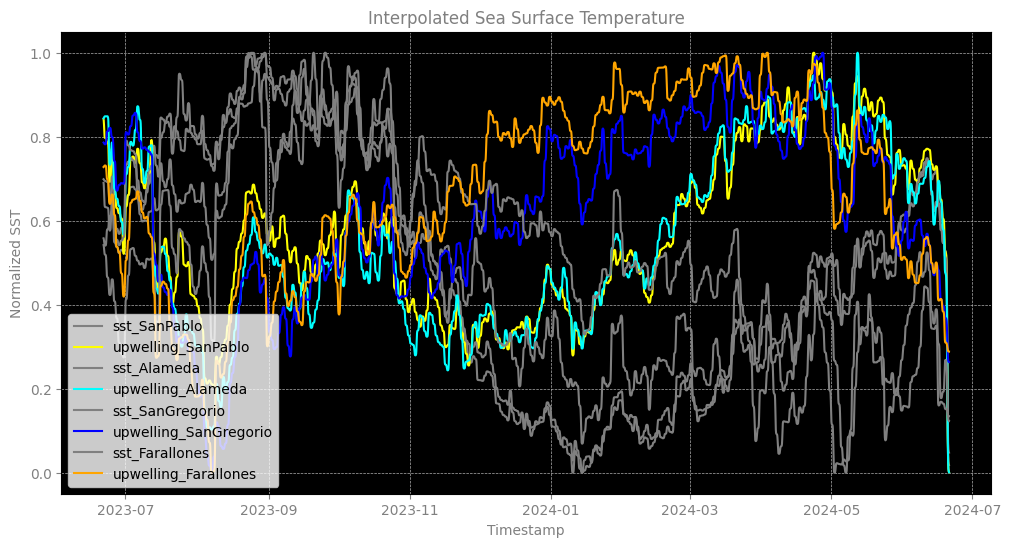

In [23]:
# Define colors for each location
colors = {
    'sst_SanPablo': 'grey',
    'sst_Alameda': 'grey',
    'sst_SanGregorio': 'grey',
    'sst_Farallones': 'grey',
    'upwelling_SanPablo': 'yellow',
    'upwelling_Alameda': 'cyan',
    'upwelling_SanGregorio': 'blue',
    'upwelling_Farallones': 'orange'
}

# Plotting
plt.figure(figsize=(12, 6))
for column in trimmed_data.columns:
    plt.plot(trimmed_data.index, trimmed_data[column], color=colors[column], label=column)

plt.xlabel('Timestamp', color='grey')
plt.ylabel('Normalized SST', color='grey')
plt.title('Interpolated Sea Surface Temperature', color='grey')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('black')
plt.gca().tick_params(colors='grey')
plt.show()

In [17]:
trimmed_data.to_csv('../data/sst_all.csv', index = True)